In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shutil
import cv2 as cv

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, save_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [2]:
data = r'/kaggle/input/cauli12/Original Dataset/'
type_disea = os.listdir(data)
print(type_disea)
for i in type_disea:
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/test', i), exist_ok=True)
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/train', i), exist_ok=True)

def split_data_files(X, Y):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
  for i in range(len(X_train)): shutil.copy(os.path.join(os.path.join(data, y_train[i]),X_train[i]), os.path.join('/kaggle/working/dataset_split/train', y_train[i]))
  for i in range(len(X_test)) : shutil.copy(os.path.join(os.path.join(data, y_test[i]),X_test[i]), os.path.join('/kaggle/working/dataset_split/test', y_test[i]))
  
for folder in type_disea:
  X,Y = [],[]
  curr_path = os.path.join(data, folder)
  for filename in os.listdir(curr_path):
    X.append(filename)
    Y.append(folder)
  split_data_files(X, Y)

['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']


In [3]:
data = '/kaggle/working/dataset_split'

In [4]:
def create_df(TYPE):
  filepaths, labels = [],[]
  data_path = os.path.join(data, TYPE)
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
  return df

train_df = create_df('train').sample(frac=1, random_state=42)
test_df = create_df('test').sample(frac=1, random_state=42)

In [5]:
batch_size=20
img_size = (224, 224)
test  = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False)

Found 133 validated image filenames belonging to 4 classes.


In [6]:
img_shape = (img_size[0], img_size[1], 3)
def get_model():
  base_model = tf.keras.applications.efficientnet.EfficientNetB2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
  base_model.trainable = True
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(4, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=outputs)
  lr=.001
  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [7]:
def make_balance(df):
  d = []
  for name_disea in type_disea:
    disea_df = df.loc[df['labels'] == name_disea]
#     print("so luong", len(disea_df))
    d.append(disea_df)
  a = pd.concat(d, axis=0)
  return a

In [8]:
def make_balance_train(df):
  minlenarr = []
  for i in type_disea:
    minlenarr.append(len(df.loc[df['labels']==i]))
  
  minlen = min(minlenarr)
  min_disea = type_disea[minlenarr.index(minlen)]
  
#   a = [df.loc[df['labels']==type_disea[0]]]
#   print(df.loc[df['labels']==type_disea[0]] )
#   a = pd.Series(df['labels'])
#   for i in type_disea:
#     a = df.loc[df['labels']==i]
  print('minlenarr ',minlenarr)
  print('type disea ',type_disea) 
  print('min len ',minlen)
  b = pd.DataFrame({})
  for i in type_disea:
    a = df.loc[df['labels'] == i]
    a = a.iloc[:minlen]
    b = pd.concat([b, a], ignore_index=True)
  print(b)
  return b


minlenarr  [113, 62, 109, 134]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  62
                                             filepaths        labels
0    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
1    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
2    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
3    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
4    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
..                                                 ...           ...
243  /kaggle/working/dataset_split/train/No disease...    No disease
244  /kaggle/working/dataset_split/train/No disease...    No disease
245  /kaggle/working/dataset_split/train/No disease...    No disease
246  /kaggle/working/dataset_split/train/No disease...    No disease
247  /kaggle/working/dataset_split/train/No disease...    No disease

[248 rows x 2 columns]
Found 248 validated image f

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726544728.024077      98 service.cc:145] XLA service 0x7eed5c004450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726544728.024155      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726544811.061765      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 250s 17s/step - accuracy: 0.4326 - loss: 1.4997 - val_accuracy: 0.3048 - val_loss: 4.5893
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8130 - loss: 0.4885 - val_accuracy: 0.4762 - val_loss: 2.8496
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9261 - loss: 0.2130 - val_accuracy: 0.5905 - val_loss: 1.9263
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9228 - loss: 0.1924 - val_accuracy: 0.6952 - val_loss: 1.1407
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9792 - loss: 0.0708 - val_accuracy: 0.7905 - val_loss: 0.8081
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.9909 - loss: 0.0317 - val_accuracy: 0.8286 - val_loss: 0.6476
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9649 - loss: 0.0941 - val_accuracy: 0.8762 - val_loss: 0.3978
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9937 - loss: 0.0173 - val_accuracy: 0.9238 - val_loss: 0.2890
Epoch 9/15
8/8 ━━

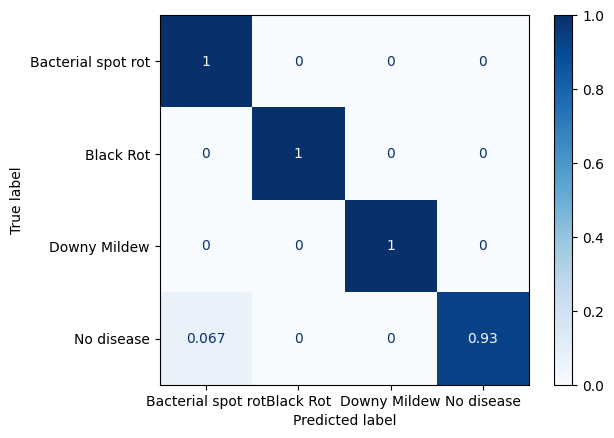

                    precision    recall  f1-score   support

Bacterial spot rot       0.91      1.00      0.96        32
         Black Rot       1.00      1.00      1.00        20
      Downy Mildew       1.00      1.00      1.00        36
        No disease       1.00      0.93      0.97        45

          accuracy                           0.98       133
         macro avg       0.98      0.98      0.98       133
      weighted avg       0.98      0.98      0.98       133

minlenarr  [114, 63, 103, 138]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  63
                                             filepaths        labels
0    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
1    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
2    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
3    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
4    /kaggle/working/dataset_split/train/Downy Mild

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 231s 16s/step - accuracy: 0.4493 - loss: 1.4038 - val_accuracy: 0.3714 - val_loss: 4.3871
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7798 - loss: 0.6821 - val_accuracy: 0.4476 - val_loss: 4.4889
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.8887 - loss: 0.3285 - val_accuracy: 0.5714 - val_loss: 2.7202
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9410 - loss: 0.1830 - val_accuracy: 0.6762 - val_loss: 1.4024
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.9720 - loss: 0.0593 - val_accuracy: 0.8000 - val_loss: 0.8345
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9846 - loss: 0.0999 - val_accuracy: 0.8381 - val_loss: 0.6283
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9634 - loss: 0.0888 - val_accuracy: 0.8381 - val_loss: 0.5115
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.9939 - loss: 0.0470 - val_accuracy: 0.8381 - val_loss: 0.4064
Epoch 9/15
8/8 ━━

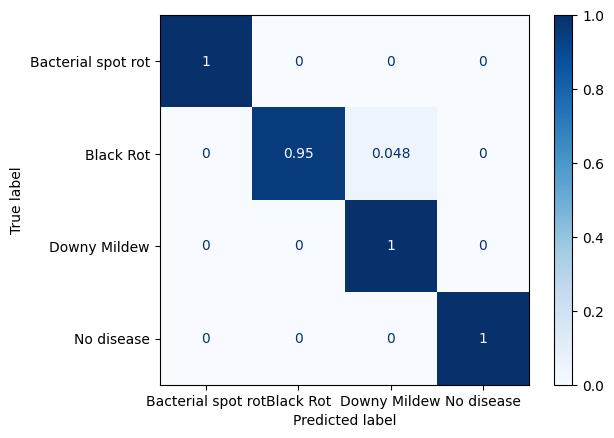

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

minlenarr  [109, 70, 111, 128]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  70
                                             filepaths        labels
0    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
1    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
2    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
3    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
4    /kaggle/working/dataset_split/train/Downy Mild

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 218s 13s/step - accuracy: 0.4145 - loss: 1.5500 - val_accuracy: 0.2571 - val_loss: 11.4887
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8962 - loss: 0.3213 - val_accuracy: 0.2762 - val_loss: 7.9946
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9038 - loss: 0.2766 - val_accuracy: 0.3238 - val_loss: 4.3220
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9586 - loss: 0.1916 - val_accuracy: 0.6190 - val_loss: 1.7184
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9720 - loss: 0.0949 - val_accuracy: 0.7429 - val_loss: 1.1085
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9949 - loss: 0.0319 - val_accuracy: 0.8190 - val_loss: 0.7905
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9796 - loss: 0.0587 - val_accuracy: 0.8571 - val_loss: 0.5392
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9868 - loss: 0.0312 - val_accuracy: 0.8762 - val_loss: 0.3768
Epoch 9/15
9/9 ━

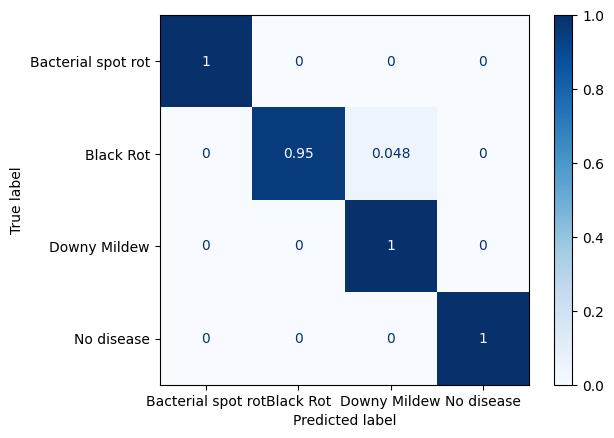

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

minlenarr  [116, 60, 108, 135]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  60
                                             filepaths        labels
0    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
1    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
2    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
3    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
4    /kaggle/working/dataset_split/train/Downy Mild

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 228s 16s/step - accuracy: 0.3813 - loss: 1.6654 - val_accuracy: 0.3942 - val_loss: 5.5066
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7264 - loss: 0.6809 - val_accuracy: 0.3558 - val_loss: 4.4560
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8715 - loss: 0.3380 - val_accuracy: 0.4519 - val_loss: 2.4718
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9319 - loss: 0.1810 - val_accuracy: 0.5385 - val_loss: 1.6958
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9685 - loss: 0.0866 - val_accuracy: 0.7019 - val_loss: 0.8950
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9937 - loss: 0.0514 - val_accuracy: 0.8173 - val_loss: 0.5542
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9912 - loss: 0.0379 - val_accuracy: 0.8750 - val_loss: 0.4315
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.9973 - loss: 0.0327 - val_accuracy: 0.8654 - val_loss: 0.4434
Epoch 9/15
8/8 ━━

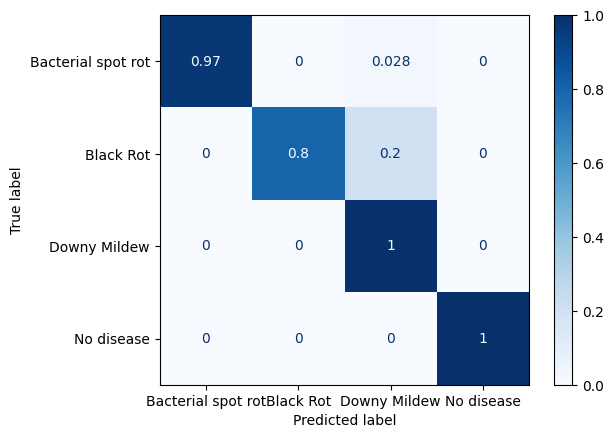

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.97      0.99        36
         Black Rot       1.00      0.80      0.89        25
      Downy Mildew       0.83      1.00      0.91        30
        No disease       1.00      1.00      1.00        42

          accuracy                           0.95       133
         macro avg       0.96      0.94      0.95       133
      weighted avg       0.96      0.95      0.95       133

minlenarr  [112, 65, 121, 121]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  65
                                             filepaths        labels
0    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
1    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
2    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
3    /kaggle/working/dataset_split/train/Downy Mild...  Downy Mildew
4    /kaggle/working/dataset_split/train/Downy Mild

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/9 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4576 - loss: 1.3920

I0000 00:00:1726547490.950912      99 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_418', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 356 bytes spill stores, 356 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_416', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_414', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 36 bytes spill stores, 36 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 237s 15s/step - accuracy: 0.4761 - loss: 1.3526 - val_accuracy: 0.4423 - val_loss: 4.8131
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8358 - loss: 0.5559 - val_accuracy: 0.5673 - val_loss: 2.5223
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8819 - loss: 0.3487 - val_accuracy: 0.6923 - val_loss: 1.0629
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.9255 - loss: 0.2196 - val_accuracy: 0.7308 - val_loss: 0.9856
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9482 - loss: 0.1687 - val_accuracy: 0.7596 - val_loss: 0.7731
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9592 - loss: 0.1026 - val_accuracy: 0.7404 - val_loss: 0.8196
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9788 - loss: 0.0794 - val_accuracy: 0.6538 - val_loss: 0.9643
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9541 - loss: 0.1277 - val_accuracy: 0.6058 - val_loss: 1.1692
Epoch 9/15
9/9 ━━

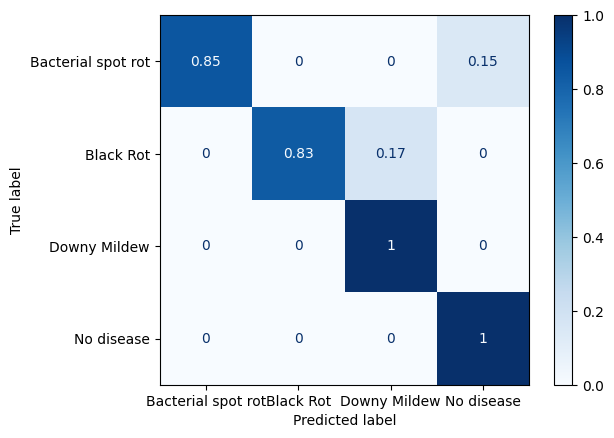

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.85      0.92        41
         Black Rot       1.00      0.83      0.91        24
      Downy Mildew       0.89      1.00      0.94        32
        No disease       0.86      1.00      0.92        36

          accuracy                           0.92       133
         macro avg       0.94      0.92      0.92       133
      weighted avg       0.93      0.92      0.92       133



In [9]:
k = StratifiedKFold(n_splits=5,shuffle=True)
k.get_n_splits(train_df['filepaths'], train_df['labels'])
epochs = 15
gen = ImageDataGenerator(horizontal_flip=True, rotation_range=30, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
for i, (train_idx, valid_idx) in enumerate(k.split(train_df['filepaths'], train_df['labels'])):
  a = make_balance_train(train_df.loc[train_idx])
  b = train_df.loc[valid_idx]
  train = gen.flow_from_dataframe(a, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)
  valid = ImageDataGenerator().flow_from_dataframe(b, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True)  
  
  model = get_model()
  history = model.fit(x=train, epochs=epochs, validation_data=valid, validation_steps=None, shuffle=False, initial_epoch=0)
  history_dict = history.history
  class_indices = list(train.class_indices.values())
  class_names = list(train.class_indices.keys())
  preds = model.predict(test)
  label = test.labels
  list_pred = []
  errors = 0
  for i, p in enumerate(preds):
    index = np.argmax(p)
    list_pred.append(index)
    if class_indices[index] != label[i]:
      errors+=1
  acc = (1.0 - errors/len(preds)) * 100
  print('Errors = ', errors, "Acc = ", acc)
  cm = confusion_matrix(list_pred, label, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  report = classification_report(list_pred, label,target_names=class_names)
  print(report)